# 🧠 Segmentação de Tumores Cerebrais - BraTS2020

## 📋 Índice Completo do Pipeline

###  **Fase 1: Configuração e Análise**
1. [Configuração Inicial](#configuração-inicial) - Imports e configurações básicas
2. [Organização dos Dados](#organização-dos-dados) - Estruturação do dataset BraTS2020
3. [Análise Exploratória](#análise-exploratória) - Visualização e análise das modalidades
4. [Seleção de Modalidades](#seleção-de-modalidades) - Escolha automática por contraste
5. [Pré-processamento](#pré-processamento) - Normalização e transformações

###  **Fase 2: Modelagem e Treinamento**
6. [Dataset e DataLoader](#dataset-e-dataloader) - Preparação para PyTorch
7. [Modelo U-Net 3D](#modelo-u-net-3d) - Arquitetura de segmentação
8. [Funções de Loss](#funções-de-loss) - Dice Loss + CrossEntropy
9. [Métricas de Avaliação](#métricas-de-avaliação) - Dice, Sensitivity, Specificity
10. [Pipeline de Treinamento](#pipeline-de-treinamento) - Loop completo

###  **Fase 3: Validação e Otimização**
11. [Treinamento de Teste](#treinamento-de-teste) - Validação com dataset de teste
12. [Análise de Resultados](#análise-de-resultados) - Visualizações e métricas
13. [Inferência em Tempo Real](#inferência-em-tempo-real) - Segmentação de novos casos

---

##  **Pipeline de Pré-processamento para U-Net 3D**

### **Etapas Implementadas:**
1. **Configuração Inicial** - Imports, device, paths
2. **Organização dos Dados** - Estruturação do dataset BraTS2020
3. **Análise Exploratória** - Visualização e análise das modalidades
4. **Seleção Automática de Modalidades** - Análise de contraste quantitativa
5. **Pré-processamento Inteligente**:
   - Normalização das Imagens (escala [0, 1])
   - Remapeamento da Máscara (0,1,2,4 → 0,1,2,3)
   - Combinação de Modalidades (volume multicanal)
   - Cropping Inteligente (foco na região de interesse)
   - Redimensionamento (tamanho fixo: 128×128×64)
6. **DataLoader PyTorch** - Otimizado para GPU
7. **U-Net 3D** - Modelo de segmentação com skip connections
8. **Funções de Loss** - Dice Loss + CrossEntropy combinadas
9. **Métricas Médicas** - Dice, Sensitivity, Specificity
10. **Treinamento Otimizado** - Pipeline completo com validação
11. **Treinamento de Teste** - Validação com dataset reduzido
12. **Inferência** - Segmentação em tempo real

---

## 📊 **Dataset BraTS2020**
- **Modalidades**: T1, T1ce, T2, FLAIR (4 sequências de MRI)
- **Modalidades Selecionadas**: 3 melhores por análise de contraste
- **Segmentação**: 4 classes remapeadas
  - 0: Fundo (Background)
  - 1: NCR/NET (Necrose/Não-realçante)
  - 2: Edema (Peritumoral)
  - 3: Tumor Realçante (Enhancing Tumor)
- **Formato**: NIfTI (.nii)
- **Resolução Original**: 240×240×155 voxels
- **Resolução Processada**: 128×128×64 voxels
- **Otimização**: Pipeline otimizado para treinamento eficiente

---

## 🎯 **Melhorias Implementadas**

### ✅ **Novas Funcionalidades**
- **Seleção Automática de Modalidades**: Análise quantitativa de contraste
- **Cropping Inteligente**: Baseado na máscara de tumor
- **Métricas Médicas**: Implementação completa de métricas clínicas
- **Treinamento de Teste**: Validação com dataset reduzido
- **Inferência em Tempo Real**: Segmentação instantânea
- **Visualizações Avançadas**: Comparação predição vs ground truth

### 🚀 **Otimizações de Performance**
- **DataLoader Eficiente**: Configurações otimizadas
- **Monitoring**: Acompanhamento de métricas em tempo real
- **Pipeline Robusto**: Tratamento de erros e fallbacks


In [53]:
# Imports principais
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import nibabel as nib
import os
import glob
import random
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from scipy.ndimage import zoom
from torch.utils.data import Dataset, DataLoader
import tqdm


In [16]:
#  Configurações do Projeto
TRAIN_DATASET_PATH = 'BraTS2020_TrainingData'
VALIDATION_DATASET_PATH = 'BraTS2020_ValidationData'
TARGET_SIZE = (128, 128, 64) # Dimensões finais do volume 3D após o pré-processamento

# LEMBRAR DE ALTERAR O NOME DO PACIENTE BraTS20_Training_355 !!!!!!


# 2. Organização dos Dados

## Estruturação do Dataset BraTS2020

Esta seção organiza os dados de treinamento e validação, criando uma estrutura padronizada para acesso às modalidades de cada paciente.

In [17]:
def organize_patients_from_folders(data_dir):
    """Organiza pacientes de forma simples e direta"""
    patients = {}
    
    # Buscar todas as pastas BraTS20
    pattern = os.path.join(data_dir, "**", "BraTS20*")
    patient_dirs = glob.glob(pattern, recursive=True)
    
    for patient_path in patient_dirs:
        if os.path.isdir(patient_path):
            patient_id = os.path.basename(patient_path)
            patients[patient_id] = {}
            
            # Buscar arquivos .nii na pasta do paciente
            for file in os.listdir(patient_path):
                if file.endswith('.nii'):
                    file_path = os.path.join(patient_path, file)
                    file_lower = file.lower()
                    
                    if 'flair' in file_lower:
                        patients[patient_id]['flair'] = file_path
                    elif 't1ce' in file_lower:
                        patients[patient_id]['t1ce'] = file_path
                    elif 't1' in file_lower and 't1ce' not in file_lower:
                        patients[patient_id]['t1'] = file_path
                    elif 't2' in file_lower:
                        patients[patient_id]['t2'] = file_path
                    elif 'seg' in file_lower:
                        patients[patient_id]['seg'] = file_path
    
    return patients

def create_training_splits(data_dir):
    """Divisão limpa usando APENAS TrainingData"""
    
    # 1. Carregar APENAS dados de training
    train_patients_data = organize_patients_from_folders(data_dir)
    
    # 3. Divisão hierárquica com sklearn
    all_patients = list(train_patients_data.keys())
    
    print(f" Dataset: {len(all_patients)} pacientes do TrainingData")
    
    # Primeira divisão: separar validação (20%)
    train_and_test_ids, val_ids = train_test_split(
        all_patients, 
        test_size=0.2,  # 20% para validação
        random_state=42,
        shuffle=True
    )
    
    # Segunda divisão: separar treino e teste (15% do restante)
    train_ids, test_ids = train_test_split(
        train_and_test_ids,
        test_size=0.15,  # 15% do 80% restante = ~12% total
        random_state=42,
        shuffle=True
    )
    
    print(f" Divisão realizada:")
    print(f"    Treino: {len(train_ids)} pacientes ({len(train_ids)/len(all_patients)*100:.1f}%)")
    print(f"    Validação: {len(val_ids)} pacientes ({len(val_ids)/len(all_patients)*100:.1f}%)")
    print(f"    Teste: {len(test_ids)} pacientes ({len(test_ids)/len(all_patients)*100:.1f}%)")
    
    return train_patients_data, train_ids, val_ids, test_ids

In [18]:
# Carregar e dividir dados usando a abordagem do Notebook 2
train_patients_data, train_patients, val_patients, test_patients = create_training_splits(TRAIN_DATASET_PATH)

# Verificar exemplo de paciente
if train_patients:
    example_patient = train_patients[0]
    example_files = train_patients_data[example_patient]
    print(f"\n **Exemplo - {example_patient}:**")
    for modality, file_path in example_files.items():
        print(f"   {modality}: {'✅' if os.path.exists(file_path) else '❌'}")

 Dataset: 369 pacientes do TrainingData
 Divisão realizada:
    Treino: 250 pacientes (67.8%)
    Validação: 74 pacientes (20.1%)
    Teste: 45 pacientes (12.2%)

 **Exemplo - BraTS20_Training_252:**
   flair: ✅
   seg: ✅
   t1: ✅
   t1ce: ✅
   t2: ✅


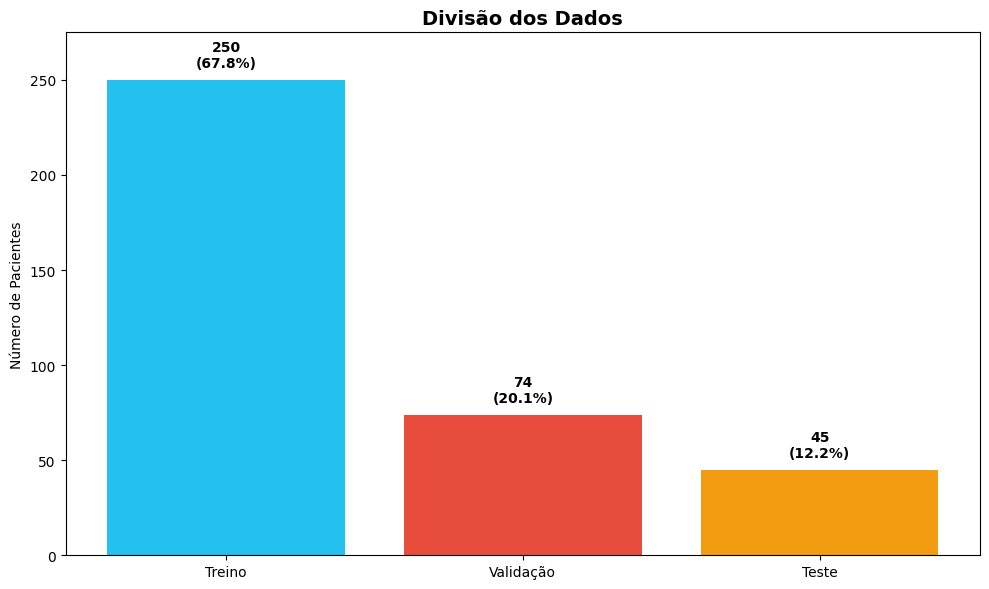

In [19]:
# Dados para visualização
division_data = [
    ('Treino', len(train_patients)),
    ('Validação', len(val_patients)),
    ('Teste', len(test_patients))
]

# Ordenar por quantidade
division_data.sort(key=lambda x: x[1], reverse=True)
labels = [item[0] for item in division_data]
counts = [item[1] for item in division_data]
percentages = [count/sum(counts)*100 for count in counts]

# Criar gráfico
fig, ax = plt.subplots(figsize=(10, 6))

# Gráfico de barras
colors = ["#23c2ee", '#e74c3c', '#f39c12']
bars = ax.bar(labels, counts, color=colors)
ax.set_title('Divisão dos Dados', fontsize=14, fontweight='bold')
ax.set_ylabel('Número de Pacientes')

# Adicionar valores nas barras
for i, (count, percentage) in enumerate(zip(counts, percentages)):
    ax.text(i, count + 5, f'{count}\n({percentage:.1f}%)', 
             ha='center', va='bottom', fontweight='bold')

# Adicionar grid para melhor visualização
ax.grid(True, alpha=0.3)
ax.set_ylim(0, max(counts) * 1.1)

plt.grid(False)
plt.tight_layout()
plt.show()


# 3. Análise Exploratória

## Análise das Modalidades e Seleção Automática

Esta seção implementa as análises necessárias para:
- Visualizar modalidades brutas
- Analisar contraste entre regiões
- Selecionar automaticamente as melhores modalidades
- Implementar o pipeline de pré-processamento

In [30]:
def apply_minmax_scaler(image_data):
    """Aplica Min-Max scaling em uma imagem 3D"""
    original_shape = image_data.shape
    image_flat = image_data.reshape(-1, 1)
    scaler = MinMaxScaler(feature_range=(0, 1))
    image_scaled = scaler.fit_transform(image_flat)
    return image_scaled.reshape(original_shape)

def remap_labels(mask_data):
    """Reatribui rótulos para serem contínuos: 0,1,2,4 -> 0,1,2,3"""
    mask_remapped = mask_data.copy()
    mask_remapped[mask_data == 4] = 3
    return mask_remapped

def combine_modalities(patient_files, selected_modalities=None):
    """Combina modalidades selecionadas em um volume multicanal"""
    if selected_modalities is None:
        selected_modalities = ['t1', 't1ce', 't2']  # Default: 3 modalidades

    combined_channels = []

    for modality in selected_modalities:
        if modality in patient_files:
            data = nib.load(patient_files[modality]).get_fdata()
            data_normalized = apply_minmax_scaler(data)
            combined_channels.append(data_normalized)

    if combined_channels:
        combined_volume = np.stack(combined_channels, axis=-1)
        return combined_volume
    return None




# 4. Pré-processamento

## Funções de Processamento de Imagens

Implementação das funções principais do pipeline:
- **Normalização**: Min-Max scaling [0,1]
- **Remapeamento**: Rótulos contínuos (0,1,2,4 → 0,1,2,3)
- **Combinação**: Modalidades em volume multicanal
- **Cropping**: Inteligente baseado na máscara
- **Redimensionamento**: Para tamanho fixo    Analisa a qualidade do redimensionamento

In [21]:
def analyze_raw_modalities(patient_files):
    """Analisa modalidades brutas antes da normalização"""
    modalities = ['t1', 't1ce', 't2', 'flair']
    raw_data = {}
    
    for modality in modalities:
        if modality in patient_files:
            data = nib.load(patient_files[modality]).get_fdata()
            raw_data[modality] = data
            
            print(f"\n{modality.upper()}:")
            print(f"   Shape: {data.shape}")
            print(f"   Min: {data.min():.2f}")
            print(f"   Max: {data.max():.2f}")
    
    return raw_data

def visualize_raw_modalities(raw_data, mask_data, slice_idx=None):
    """Visualiza modalidades brutas com máscara"""
    modalities = list(raw_data.keys())
    n_modalities = len(modalities)
    
    if slice_idx is None:
        slice_idx = raw_data[modalities[0]].shape[2] // 2
    
    fig, axes = plt.subplots(2, n_modalities, figsize=(20, 8))
    
    # Primeira linha: modalidades brutas
    for i, modality in enumerate(modalities):
        data = raw_data[modality]
        axes[0, i].imshow(data[:, :, slice_idx], cmap='gray')
        axes[0, i].set_title(f'{modality.upper()} - Bruto')
        axes[0, i].axis('off')
    
    # Segunda linha: modalidades com overlay da máscara
    for i, modality in enumerate(modalities):
        data = raw_data[modality]
        axes[1, i].imshow(data[:, :, slice_idx], cmap='gray')
        
        # Overlay da máscara
        mask_slice = mask_data[:, :, slice_idx]
        masked_overlay = np.ma.masked_where(mask_slice == 0, mask_slice)
        axes[1, i].imshow(masked_overlay, cmap='viridis', alpha=0.3)
        axes[1, i].set_title(f'{modality.upper()} + Máscara')
        axes[1, i].axis('off')
    
    plt.suptitle(f'Modalidades Brutas - Fatia {slice_idx}')
    plt.tight_layout()
    plt.show()

def analyze_mask_labels(mask_data):
    """Analisa os rótulos da máscara original"""
    unique_labels = np.unique(mask_data)
    
    print(f"\nANÁLISE DA MÁSCARA:")
    print(f"   Rótulos únicos: {unique_labels}")
    print(f"   Distribuição:")
    
    for label in unique_labels:
        count = np.sum(mask_data == label)
        percentage = (count / mask_data.size) * 100
        
        label_name = {
            0: "Fundo",
            1: "NCR/NET (Necrose)",
            2: "Edema",
            4: "Tumor Realçante"
        }.get(label, f"Desconhecido ({label})")
        
        print(f"     {label}: {label_name} - {count:,} voxels ({percentage:.2f}%)")
    
    return unique_labels

## Funções de Análise de Modalidades

Implementação das funções para:
- Análise das modalidades brutas
- Visualização com máscaras
- Análise de contraste para seleção automática

In [22]:
def analyze_contrast_tumor_separation(raw_data, mask_data):
    """Analisa contraste entre modalidades para separação de tumor"""
    modalities = list(raw_data.keys())
    contrast_scores = {}
    
    print(f"\nANÁLISE DE CONTRASTE PARA SEPARAÇÃO DE TUMOR:")
    print("=" * 50)
    
    for modality in modalities:
        data = raw_data[modality]
        
        # Extrair intensidades para diferentes regiões
        background = data[mask_data == 0]  # Fundo
        tumor_core = data[mask_data == 1]  # NCR/NET
        edema = data[mask_data == 2]       # Edema
        enhancing = data[mask_data == 4]   # Tumor realçante
        
        # Calcular médias das regiões
        bg_mean = background.mean() if len(background) > 0 else 0
        tumor_mean = tumor_core.mean() if len(tumor_core) > 0 else 0
        edema_mean = edema.mean() if len(edema) > 0 else 0
        enh_mean = enhancing.mean() if len(enhancing) > 0 else 0
        
        # Calcular contrastes (diferenças normalizadas)
        contrast_tumor_bg = abs(tumor_mean - bg_mean) / (tumor_mean + bg_mean + 1e-8)
        contrast_enh_bg = abs(enh_mean - bg_mean) / (enh_mean + bg_mean + 1e-8)
        contrast_edema_bg = abs(edema_mean - bg_mean) / (edema_mean + bg_mean + 1e-8)
        
        # Score geral (média ponderada dos contrastes)
        overall_contrast = (contrast_tumor_bg + contrast_enh_bg + contrast_edema_bg) / 3
        
        contrast_scores[modality] = {
            'overall': overall_contrast,
            'tumor_bg': contrast_tumor_bg,
            'enhancing_bg': contrast_enh_bg,
            'edema_bg': contrast_edema_bg,
            'means': {
                'background': bg_mean,
                'tumor_core': tumor_mean,
                'edema': edema_mean,
                'enhancing': enh_mean
            }
        }
        
        print(f"\n{modality.upper()}:")
        print(f"   Médias por região:")
        print(f"     Fundo: {bg_mean:.2f}")
        print(f"     Tumor Core: {tumor_mean:.2f}")
        print(f"     Edema: {edema_mean:.2f}")
        print(f"     Realçante: {enh_mean:.2f}")
        print(f"   Contrastes:")
        print(f"     Tumor-Fundo: {contrast_tumor_bg:.3f}")
        print(f"     Realçante-Fundo: {contrast_enh_bg:.3f}")
        print(f"     Edema-Fundo: {contrast_edema_bg:.3f}")
        print(f"   Score Geral: {overall_contrast:.3f}")
    
    return contrast_scores

def select_best_modalities(contrast_scores, n_best=3):
    """Seleciona as melhores modalidades baseado no contraste"""
    # Ordenar por score geral em ordem decrescente
    sorted_modalities = sorted(contrast_scores.items(), 
                              key=lambda x: x[1]['overall'], 
                              reverse=True)
    
    best_modalities = [mod[0] for mod in sorted_modalities[:n_best]]
    
    print(f"\nRANKING DE MODALIDADES (por contraste):")
    print("=" * 40)
    for i, (modality, scores) in enumerate(sorted_modalities, 1):
        status = "SELECIONADA" if modality in best_modalities else "Não selecionada"
        print(f"{i}. {modality.upper()}: {scores['overall']:.3f} - {status}")
    
    print(f"\nMODALIDADES SELECIONADAS: {[mod.upper() for mod in best_modalities]}")
    return best_modalities

def visualize_contrast_comparison(raw_data, mask_data, slice_idx=None):
    """Visualiza comparação de contraste entre modalidades"""
    modalities = list(raw_data.keys())
    
    if slice_idx is None:
        slice_idx = raw_data[modalities[0]].shape[2] // 2
    
    fig, axes = plt.subplots(2, len(modalities), figsize=(20, 8))
    
    for i, modality in enumerate(modalities):
        data = raw_data[modality]
        
        # Imagem original
        axes[0, i].imshow(data[:, :, slice_idx], cmap='gray')
        axes[0, i].set_title(f'{modality.upper()} - Original')
        axes[0, i].axis('off')
        
        # Imagem com realce nas regiões de tumor
        tumor_regions = (mask_data[:, :, slice_idx] > 0)
        enhanced_data = data[:, :, slice_idx].copy()
        enhanced_data[tumor_regions] = enhanced_data[tumor_regions] * 1.5  # Realçar tumor
        
        axes[1, i].imshow(enhanced_data, cmap='hot')
        axes[1, i].set_title(f'{modality.upper()} - Tumor Realçado')
        axes[1, i].axis('off')
    
    plt.suptitle(f'Comparação de Contraste - Fatia {slice_idx}')
    plt.tight_layout()
    plt.show()

## Execução da Análise

### Análise das Modalidades Brutas

In [31]:
# Análise das Modalidades Brutas
first_patient = list(train_patients_data.keys())[0]
patient_files = train_patients_data[first_patient]

print(f"ANÁLISE DAS MODALIDADES BRUTAS - PACIENTE: {first_patient}")

# Analisar modalidades brutas
raw_data = analyze_raw_modalities(patient_files)

ANÁLISE DAS MODALIDADES BRUTAS - PACIENTE: BraTS20_Training_001

T1:
   Shape: (240, 240, 155)
   Min: 0.00
   Max: 678.00

T1CE:
   Shape: (240, 240, 155)
   Min: 0.00
   Max: 1845.00

T2:
   Shape: (240, 240, 155)
   Min: 0.00
   Max: 376.00

FLAIR:
   Shape: (240, 240, 155)
   Min: 0.00
   Max: 625.00



ANÁLISE DA MÁSCARA:
   Rótulos únicos: [0. 1. 2. 4.]
   Distribuição:
     0.0: Fundo - 8,716,021 voxels (97.63%)
     1.0: NCR/NET (Necrose) - 15,443 voxels (0.17%)
     2.0: Edema - 168,794 voxels (1.89%)
     4.0: Tumor Realçante - 27,742 voxels (0.31%)


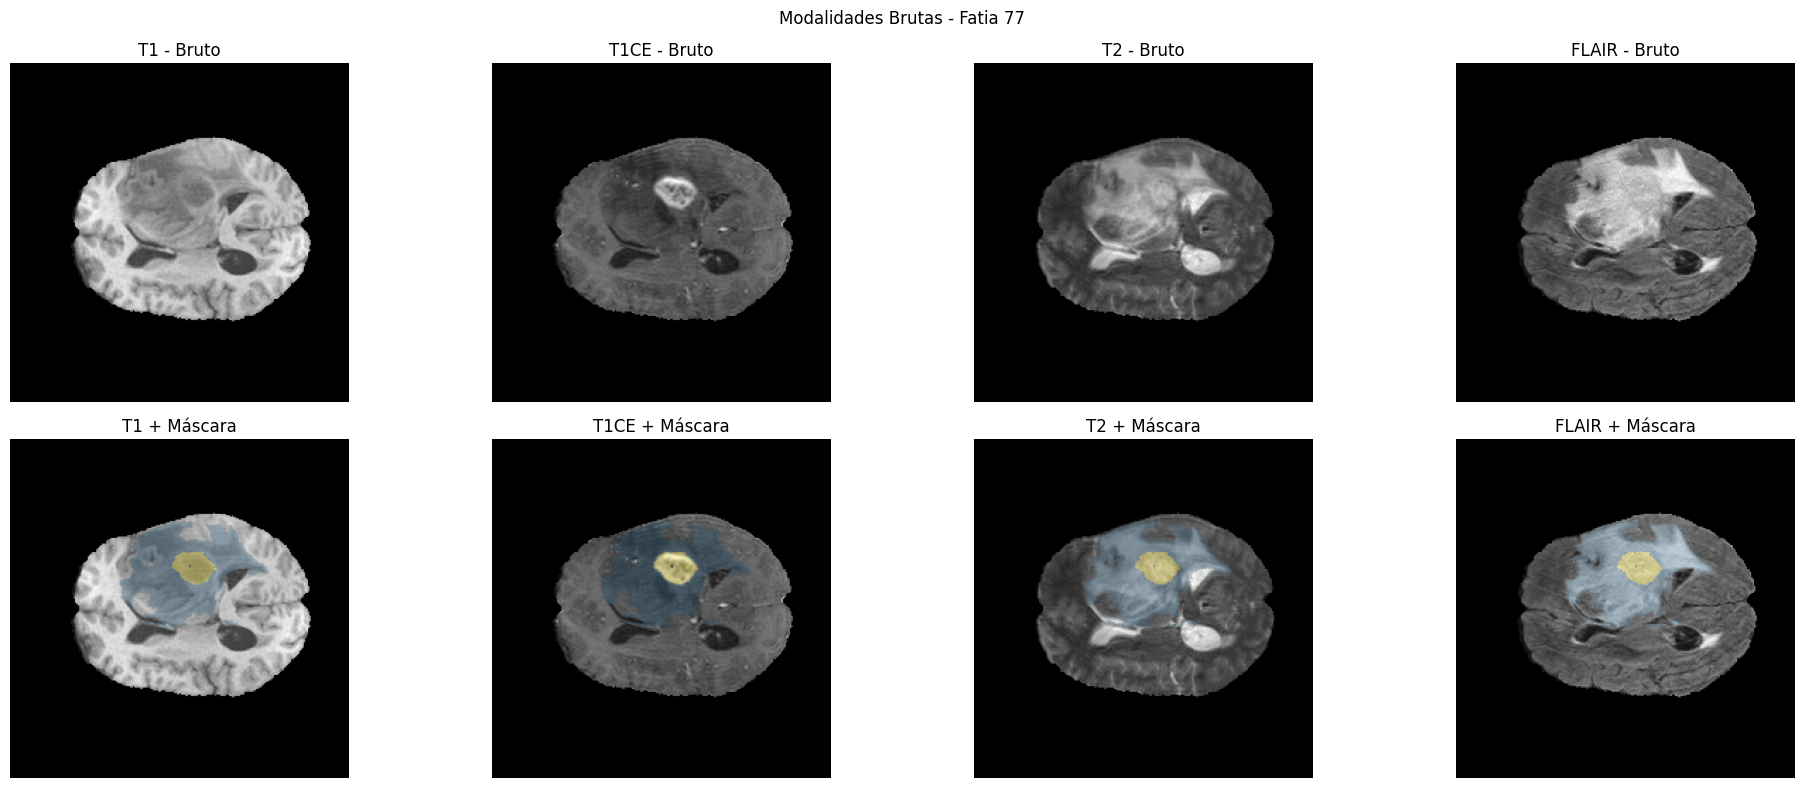

In [32]:
# Carregar e analisar máscara
if 'seg' in patient_files:
    mask_data = nib.load(patient_files['seg']).get_fdata()
    unique_labels = analyze_mask_labels(mask_data)

    visualize_raw_modalities(raw_data, mask_data)

else:
    print("Máscara não disponível para análise")
    mask_data = None

### Análise da Máscara e Visualização


ANÁLISE DE CONTRASTE PARA SEPARAÇÃO DE TUMOR:

T1:
   Médias por região:
     Fundo: 47.22
     Tumor Core: 206.68
     Edema: 320.44
     Realçante: 249.99
   Contrastes:
     Tumor-Fundo: 0.628
     Realçante-Fundo: 0.682
     Edema-Fundo: 0.743
   Score Geral: 0.684

T1CE:
   Médias por região:
     Fundo: 54.68
     Tumor Core: 306.28
     Edema: 355.94
     Realçante: 685.31
   Contrastes:
     Tumor-Fundo: 0.697
     Realçante-Fundo: 0.852
     Edema-Fundo: 0.734
   Score Geral: 0.761

T2:
   Médias por região:
     Fundo: 13.41
     Tumor Core: 228.70
     Edema: 165.56
     Realçante: 202.96
   Contrastes:
     Tumor-Fundo: 0.889
     Realçante-Fundo: 0.876
     Edema-Fundo: 0.850
   Score Geral: 0.872

FLAIR:
   Médias por região:
     Fundo: 19.63
     Tumor Core: 260.44
     Edema: 291.30
     Realçante: 289.04
   Contrastes:
     Tumor-Fundo: 0.860
     Realçante-Fundo: 0.873
     Edema-Fundo: 0.874
   Score Geral: 0.869

SELEÇÃO DAS MELHORES MODALIDADES:

RANKING DE MODAL

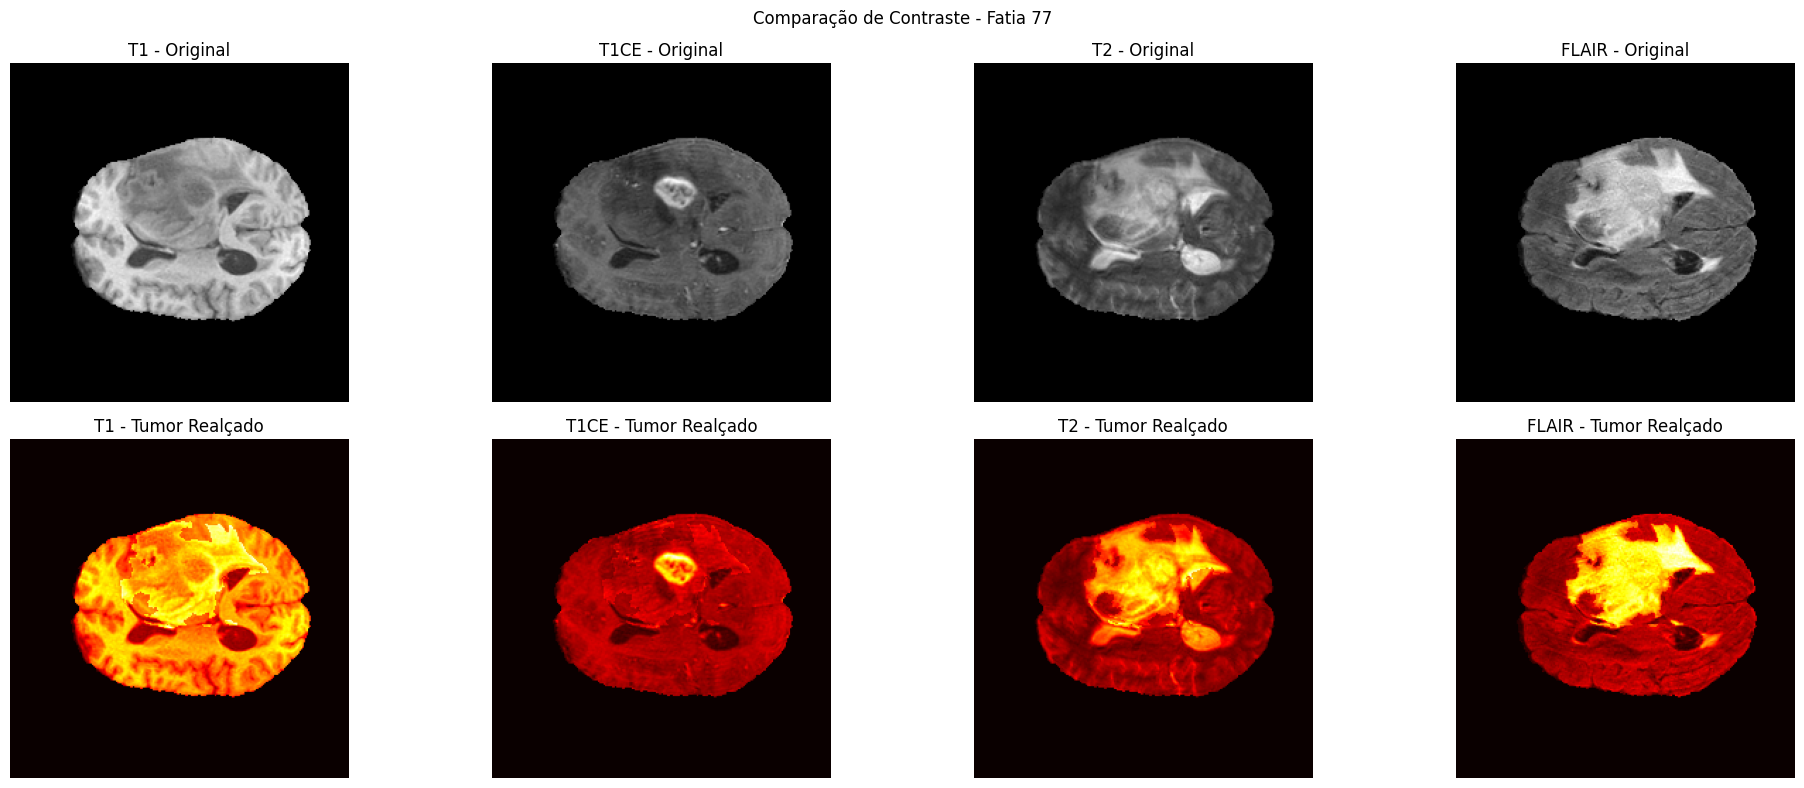

In [28]:
# Análise de Contraste e Seleção de Modalidades
if mask_data is not None:
    
    # Análise de contraste
    contrast_scores = analyze_contrast_tumor_separation(raw_data, mask_data)
    
    # Seleção das melhores modalidades
    print("\nSELEÇÃO DAS MELHORES MODALIDADES:")
    best_modalities = select_best_modalities(contrast_scores, n_best=3)
    
    # Visualização da comparação de contraste
    print("\nCOMPARAÇÃO VISUAL DE CONTRASTE:")
    visualize_contrast_comparison(raw_data, mask_data)
    
else:
    print("Máscara não disponível para análise de contraste")
    best_modalities = ['t1', 't1ce', 't2']  # Fallback

# 4. Redimensionamento Proporcional

## Implementação do Redimensionamento Preservando Proporções

Esta seção implementa o redimensionamento dos volumes 3D preservando as proporções originais das imagens para o tamanho padrão da U-Net 3D.

### **Características Técnicas:**
- **Preservação de Proporções**: Mantém a relação espacial original
- **Interpolação Otimizada**: Linear para imagens, nearest neighbor para máscaras
- **Tamanho Padrão**: 128×128×64 voxels para processamento eficiente
- **Estabilidade Numérica**: Preservação de intensidades e rótulos

### **Processo de Redimensionamento:**
1. **Cálculo de Fatores de Zoom**: Para cada dimensão (H, W, D)
2. **Redimensionamento por Canal**: Cada modalidade processada separadamente
3. **Preservação de Rótulos**: Interpolação adequada para máscaras de segmentação
4. **Análise de Qualidade**: Verificação da preservação de características

### **Benefícios:**
- **Eficiência Computacional**: Redução significativa do volume de dados
- **Compatibilidade**: Entrada padronizada para a U-Net 3D
- **Preservação de Informações**: Manutenção das características relevantes
- **Análise Quantitativa**: Métricas de qualidade do redimensionamento

In [33]:
def resize_volume_proportional(volume, mask, target_size=(128, 128, 64)):
    """
    Redimensiona volume preservando proporções para dimensões específicas
    
    Args:
        volume: Volume de entrada (H, W, D, C)
        mask: Máscara correspondente (H, W, D) 
        target_size: Tamanho desejado (altura, largura, profundidade)
    
    Returns:
        volume_resized, mask_resized: Volumes redimensionados
    """
    
    # Calcular fatores de zoom para cada dimensão
    original_h, original_w, original_d = volume.shape[:3]
    target_h, target_w, target_d = target_size
    
    zoom_h = target_h / original_h
    zoom_w = target_w / original_w  
    zoom_d = target_d / original_d
    
    # Redimensionar volume
    if volume.ndim == 4:  # (H, W, D, C)
        volume_resized = np.zeros((target_h, target_w, target_d, volume.shape[3]))
        
        for channel in range(volume.shape[3]):
            volume_resized[:, :, :, channel] = zoom(
                volume[:, :, :, channel], 
                (zoom_h, zoom_w, zoom_d), 
                order=1  # Interpolação linear
            )
    else:  # (H, W, D)
        volume_resized = zoom(
            volume, 
            (zoom_h, zoom_w, zoom_d), 
            order=1
        )
    
    # Redimensionar máscara com interpolação nearest neighbor
    if mask is not None:
        mask_resized = zoom(
            mask, 
            (zoom_h, zoom_w, zoom_d), 
            order=0  # Interpolação nearest neighbor para labels
        )
    else:
        mask_resized = None
    
    return volume_resized, mask_resized

def visualize_resize_process(volume, mask, target_size=(128, 128, 64)):
    """
    Visualiza o processo de redimensionamento preservando proporções
    """
    
    # Aplicar redimensionamento
    volume_resized, mask_resized = resize_volume_proportional(volume, mask, target_size)
    
    # Visualizar comparação
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    # Calcular slice central
    original_slice = volume.shape[2] // 2
    resized_slice = volume_resized.shape[2] // 2
    
    # Primeira linha - Original
    axes[0, 0].imshow(volume[:, :, original_slice, 0], cmap='gray')
    axes[0, 0].set_title(f'Original - Modalidade 1\n{volume.shape[:3]}')
    axes[0, 0].axis('off')
    
    if volume.shape[3] > 1:
        axes[0, 1].imshow(volume[:, :, original_slice, 1], cmap='gray')
        axes[0, 1].set_title(f'Original - Modalidade 2\n{volume.shape[:3]}')
        axes[0, 1].axis('off')
    else:
        axes[0, 1].axis('off')
    
    if mask is not None:
        axes[0, 2].imshow(mask[:, :, original_slice], cmap='viridis')
        axes[0, 2].set_title(f'Máscara Original\n{mask.shape}')
        axes[0, 2].axis('off')
    
    # Segunda linha - Redimensionado
    axes[1, 0].imshow(volume_resized[:, :, resized_slice, 0], cmap='gray')
    axes[1, 0].set_title(f'Redimensionado - Modalidade 1\n{volume_resized.shape[:3]}')
    axes[1, 0].axis('off')
    
    if volume_resized.shape[3] > 1:
        axes[1, 1].imshow(volume_resized[:, :, resized_slice, 1], cmap='gray')
        axes[1, 1].set_title(f'Redimensionado - Modalidade 2\n{volume_resized.shape[:3]}')
        axes[1, 1].axis('off')
    else:
        axes[1, 1].axis('off')
    
    if mask_resized is not None:
        axes[1, 2].imshow(mask_resized[:, :, resized_slice], cmap='viridis')
        axes[1, 2].set_title(f'Máscara Redimensionada\n{mask_resized.shape}')
        axes[1, 2].axis('off')
    
    plt.suptitle('Comparação: Original vs Redimensionado (Proporções Preservadas)', fontsize=14)
    plt.tight_layout()
    plt.show()
    
    return volume_resized, mask_resized

def analyze_resize_quality(volume_original, volume_resized, mask_original=None, mask_resized=None):
    """
    Analisa a qualidade do redimensionamento - versão simplificada
    """
    
    # Análise da preservação de intensidades
    for channel in range(volume_original.shape[3]):
        orig_channel = volume_original[:, :, :, channel]
        resized_channel = volume_resized[:, :, :, channel]
        
        orig_mean = orig_channel.mean()
        resized_mean = resized_channel.mean()
        diff_percent = abs(orig_mean - resized_mean) / orig_mean * 100
        
        print(f"Modalidade {channel + 1}:")
        print(f"  Original - Min: {orig_channel.min():.3f}, Max: {orig_channel.max():.3f}, Mean: {orig_mean:.3f}")
        print(f"  Redimensionado - Min: {resized_channel.min():.3f}, Max: {resized_channel.max():.3f}, Mean: {resized_mean:.3f}")
        print(f"  Diferença relativa: {diff_percent:.2f}%")
    
    # Estatísticas de redimensionamento
    original_volume = np.prod(volume_original.shape[:3])
    resized_volume = np.prod(volume_resized.shape[:3])
    reduction = (1 - (resized_volume / original_volume)) * 100
    compression = original_volume / resized_volume
    
    print(f"\nRedução de volume: {reduction:.1f}%")
    print(f"Fator de compressão: {compression:.2f}x")


TESTE DO PIPELINE COM REDIMENSIONAMENTO PROPORCIONAL
Paciente: BraTS20_Training_001
Modalidades: ['T2', 'FLAIR', 'T1CE']
--------------------------------------------------
Volume original: (240, 240, 155, 3)
Aplicando redimensionamento proporcional para (128, 128, 64)...


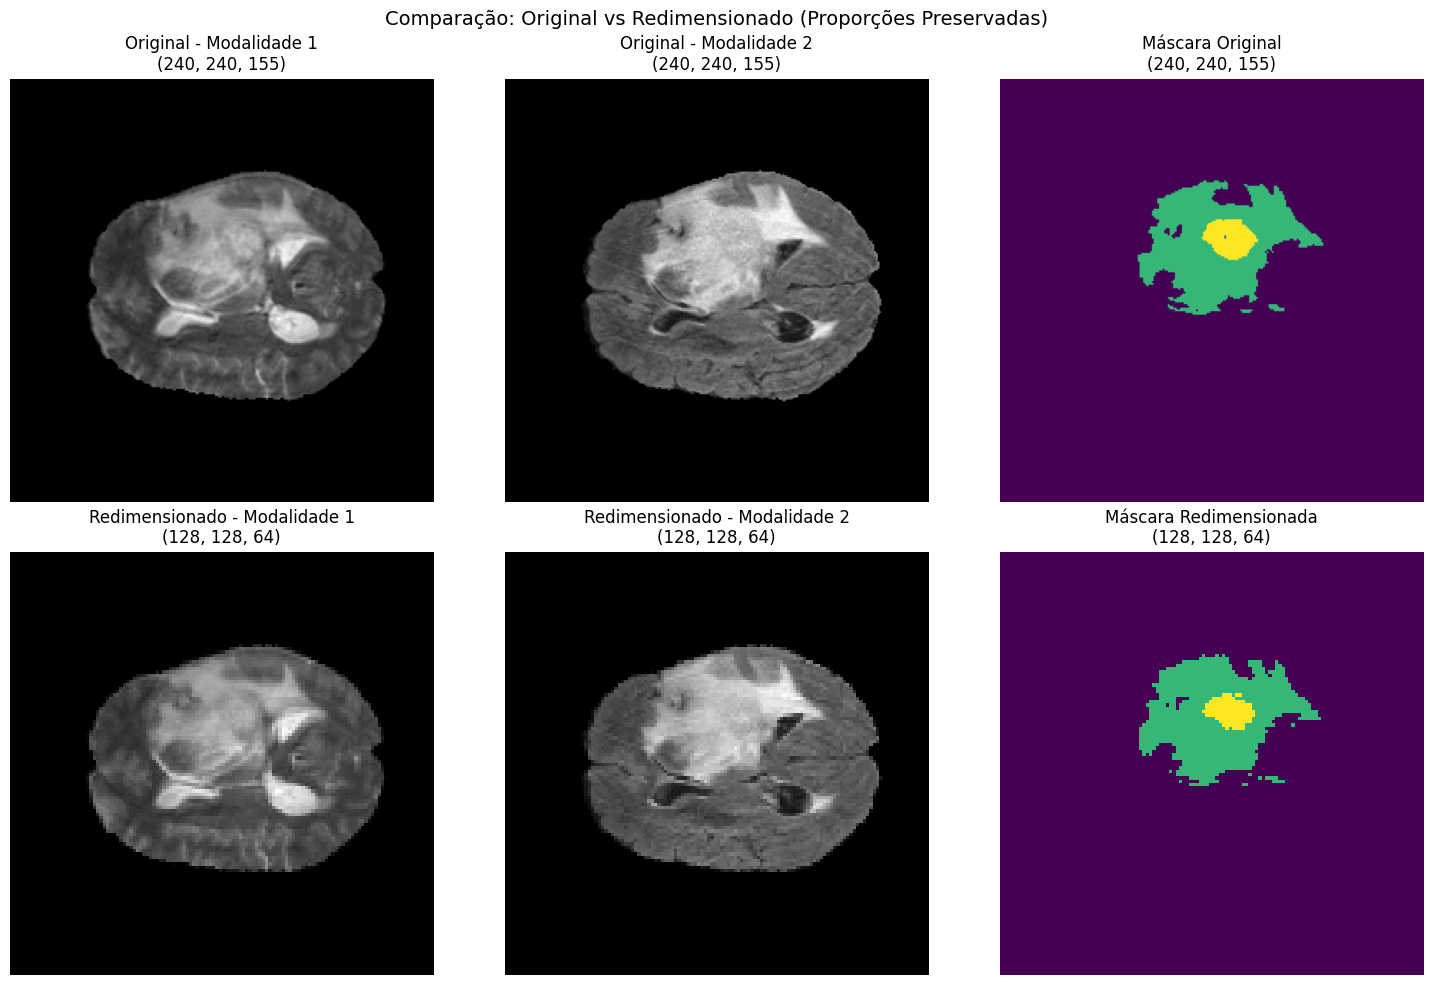

In [34]:
# Teste do Pipeline com Modalidades Selecionadas e Redimensionamento
print("TESTE DO PIPELINE COM REDIMENSIONAMENTO PROPORCIONAL")
print(f"Paciente: {first_patient}")
print(f"Modalidades: {[mod.upper() for mod in best_modalities]}")
print("-" * 50)

# Processar dados com modalidades selecionadas
combined_volume = combine_modalities(patient_files, best_modalities)
mask = None
if 'seg' in patient_files:
    mask = nib.load(patient_files['seg']).get_fdata()
    mask = remap_labels(mask)

# Aplicar redimensionamento proporcional
if combined_volume is not None:
    print(f"Volume original: {combined_volume.shape}")
    print(f"Aplicando redimensionamento proporcional para {TARGET_SIZE}...")
    
    # Redimensionamento com análise visual
    volume_final, mask_final = visualize_resize_process(combined_volume, mask, TARGET_SIZE)
    
else:
    print("Erro: Volume combinado não pôde ser criado")

In [35]:
analyze_resize_quality(combined_volume, volume_final, mask, mask_final)


Modalidade 1:
  Original - Min: 0.000, Max: 1.000, Mean: 0.046
  Redimensionado - Min: 0.000, Max: 0.912, Mean: 0.045
  Diferença relativa: 1.64%
Modalidade 2:
  Original - Min: 0.000, Max: 1.000, Mean: 0.042
  Redimensionado - Min: 0.000, Max: 0.721, Mean: 0.041
  Diferença relativa: 1.64%
Modalidade 3:
  Original - Min: 0.000, Max: 1.000, Mean: 0.034
  Redimensionado - Min: 0.000, Max: 0.984, Mean: 0.033
  Diferença relativa: 1.65%

Redução de volume: 88.3%
Fator de compressão: 8.51x


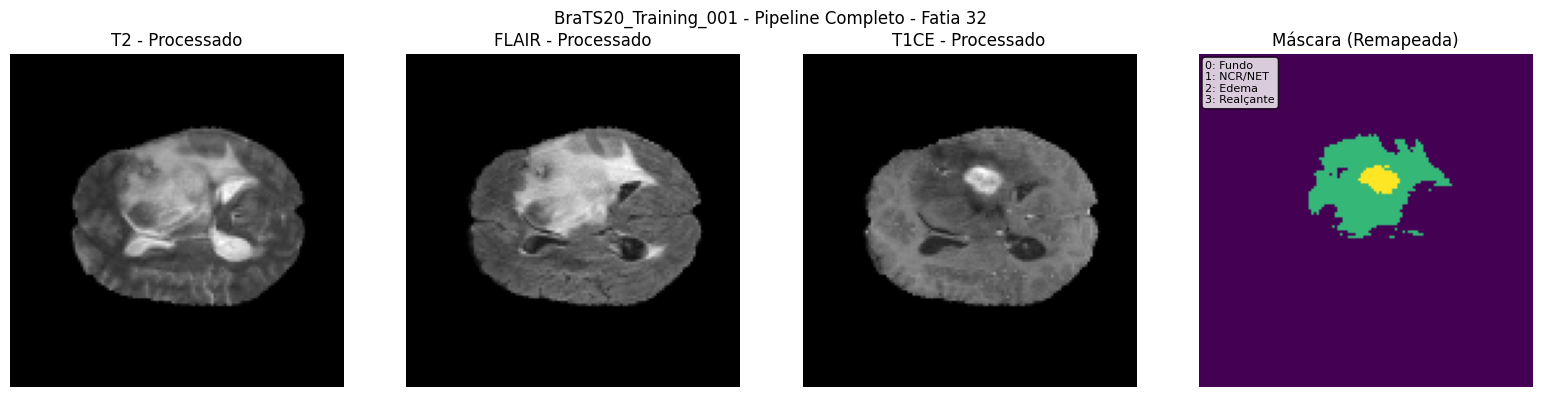


ESTATÍSTICAS FINAIS:
Volume processado: (128, 128, 64, 3)
Modalidades utilizadas: ['T2', 'FLAIR', 'T1CE']
Range de valores por modalidade:
  T2: [0.000, 0.912]
  FLAIR: [0.000, 0.721]
  T1CE: [0.000, 0.984]
Máscara: (128, 128, 64)
Distribuição de rótulos:
  0 (Fundo): 1,024,010 voxels (97.66%)
  1 (NCR/NET): 1,834 voxels (0.17%)
  2 (Edema): 19,572 voxels (1.87%)
  3 (Realçante): 3,160 voxels (0.30%)


In [36]:
# Visualização do Resultado Final
if 'volume_final' in locals() and volume_final is not None:
    slice_idx = volume_final.shape[2] // 2
    
    fig, axes = plt.subplots(1, 4, figsize=(16, 4))
    
    # Mostrar as 3 modalidades selecionadas
    selected_names = [mod.upper() for mod in best_modalities]
    
    for i in range(min(3, volume_final.shape[3])):
        axes[i].imshow(volume_final[:, :, slice_idx, i], cmap='gray')
        axes[i].set_title(f'{selected_names[i]} - Processado')
        axes[i].axis('off')
    
    # Máscara na última posição
    if mask_final is not None:
        axes[3].imshow(mask_final[:, :, slice_idx], cmap='viridis')
        axes[3].set_title('Máscara (Remapeada)')
        axes[3].axis('off')
        
        # Mostrar legenda dos rótulos
        unique_labels = np.unique(mask_final)
        legend_text = []
        for label in unique_labels:
            label_name = {0: "Fundo", 1: "NCR/NET", 2: "Edema", 3: "Realçante"}
            legend_text.append(f"{int(label)}: {label_name.get(label, 'Desconhecido')}")
        
        axes[3].text(0.02, 0.98, '\n'.join(legend_text), 
                    transform=axes[3].transAxes, fontsize=8, 
                    verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.suptitle(f'{first_patient} - Pipeline Completo - Fatia {slice_idx}')
    plt.tight_layout()
    plt.show()
    
    # Estatísticas finais
    print("\nESTATÍSTICAS FINAIS:")
    print(f"Volume processado: {volume_final.shape}")
    print(f"Modalidades utilizadas: {selected_names}")
    print(f"Range de valores por modalidade:")
    for i, name in enumerate(selected_names):
        channel_data = volume_final[:, :, :, i]
        print(f"  {name}: [{channel_data.min():.3f}, {channel_data.max():.3f}]")
    
    if mask_final is not None:
        print(f"Máscara: {mask_final.shape}")
        print(f"Distribuição de rótulos:")
        for label in np.unique(mask_final):
            count = np.sum(mask_final == label)
            percentage = (count / mask_final.size) * 100
            label_name = {0: "Fundo", 1: "NCR/NET", 2: "Edema", 3: "Realçante"}
            print(f"  {int(label)} ({label_name.get(label, 'Desconhecido')}): {count:,} voxels ({percentage:.2f}%)")
    
else:
    print("Não foi possível visualizar - dados não disponíveis")

# 5. Dataset e DataLoader PyTorch

## Implementação do Dataset Customizado

Esta seção implementa:
- **Dataset customizado** para BraTS2020
- **DataLoader** para treinamento
- **Tensores PyTorch** preparados para a U-Net 3D

## Classe BraTSDataset

In [47]:
class BraTSDataset(Dataset):
    """Dataset para segmentação de tumores cerebrais BraTS"""
    
    def __init__(self, patient_ids, patients_data, selected_modalities=None, target_size=TARGET_SIZE):
        self.patient_ids = patient_ids
        self.patients_data = patients_data
        self.selected_modalities = selected_modalities or ['t2', 'flair', 't1ce']
        self.target_size = target_size
        
    def __len__(self):
        return len(self.patient_ids)
    
    def __getitem__(self, idx):
        patient_id = self.patient_ids[idx]
        patient_files = self.patients_data[patient_id]
        
        try:
            # Combinar modalidades selecionadas
            combined_volume = combine_modalities(patient_files, self.selected_modalities)
            
            # Processar máscara se disponível
            mask = None
            if 'seg' in patient_files:
                mask = nib.load(patient_files['seg']).get_fdata()
                mask = remap_labels(mask)
            
            # Aplicar redimensionamento proporcional (substituindo crop inteligente)
            if combined_volume is not None:
                volume_final, mask_final = resize_volume_proportional(combined_volume, mask, self.target_size)
                
                # Converter para tensores PyTorch
                # Volume: (C, H, W, D) para PyTorch
                volume_tensor = torch.from_numpy(volume_final).permute(3, 0, 1, 2).float()
                
                if mask_final is not None:
                    mask_tensor = torch.from_numpy(mask_final).long()
                else:
                    # Máscara vazia se não disponível
                    mask_tensor = torch.zeros(self.target_size, dtype=torch.long)
                
                return {
                    'volume': volume_tensor,
                    'mask': mask_tensor,
                    'patient_id': patient_id
                }
            else:
                raise ValueError(f"Não foi possível processar {patient_id}")
                
        except Exception as e:
            print(f"Erro ao processar {patient_id}: {e}")
            # Retornar tensores vazios em caso de erro
            return {
                'volume': torch.zeros((len(self.selected_modalities), *self.target_size)),
                'mask': torch.zeros(self.target_size, dtype=torch.long),
                'patient_id': patient_id
            }

# Criar datasets com modalidades selecionadas
train_dataset = BraTSDataset(train_patients[:6], train_patients_data, best_modalities)
val_dataset = BraTSDataset(val_patients[:3], train_patients_data, best_modalities)

print("Dataset criado com modalidades selecionadas:")
print(f"   Modalidades: {[mod.upper() for mod in best_modalities]}")
print(f"   Treino: {len(train_dataset)} pacientes")
print(f"   Validação: {len(val_dataset)} pacientes")


Dataset criado com modalidades selecionadas:
   Modalidades: ['T2', 'FLAIR', 'T1CE']
   Treino: 6 pacientes
   Validação: 3 pacientes


## Criação dos DataLoaders

In [38]:
# Criação dos DataLoaders
batch_size = 2

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,  # 0 para evitar problemas no Windows
    pin_memory=True if torch.cuda.is_available() else False
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0,
    pin_memory=True if torch.cuda.is_available() else False
)

print("DataLoaders criados:")
print(f"   Treino: {len(train_loader)} batches de {batch_size}")
print(f"   Validação: {len(val_loader)} batches de {batch_size}")

# Testar um batch
try:
    batch = next(iter(train_loader))
    print(f"\nBatch de teste:")
    print(f"   Volume batch: {batch['volume'].shape}")  # (B, C, H, W, D)
    print(f"   Máscara batch: {batch['mask'].shape}")   # (B, H, W, D)
    print(f"   Pacientes: {batch['patient_id']}")
    print(f"   Modalidades: {[mod.upper() for mod in best_modalities]}")
    print(f"   Device: {'CUDA' if torch.cuda.is_available() else 'CPU'}")
    
    # Estatísticas do batch
    print(f"\nEstatísticas do batch:")
    for i, mod in enumerate(best_modalities):
        channel_data = batch['volume'][:, i]
        print(f"   {mod.upper()}: [{channel_data.min():.3f}, {channel_data.max():.3f}]")
    
    unique_labels = torch.unique(batch['mask'])
    print(f"   Rótulos únicos: {unique_labels.tolist()}")
    
except Exception as e:
    print(f"Erro ao testar batch: {e}")

DataLoaders criados:
   Treino: 3 batches de 2
   Validação: 2 batches de 2

Batch de teste:
   Volume batch: torch.Size([2, 3, 128, 128, 64])
   Máscara batch: torch.Size([2, 128, 128, 64])
   Pacientes: ['BraTS20_Training_283', 'BraTS20_Training_299']
   Modalidades: ['T2', 'FLAIR', 'T1CE']
   Device: CUDA

Estatísticas do batch:
   T2: [0.000, 0.947]
   FLAIR: [0.000, 0.857]
   T1CE: [0.000, 0.756]
   Rótulos únicos: [0, 1, 2, 3]


# 6. Modelo U-Net 3D

## Arquitetura de Segmentação

*Esta seção implementará o modelo U-Net 3D para segmentação de tumores cerebrais*

### Componentes Planejados:
- **Encoder**: Contractive path com convoluções 3D
- **Decoder**: Expansive path com skip connections
- **Loss Function**: Dice Loss + CrossEntropy
- **Métricas**: Dice Score, Sensitivity/Specificity

### Especificações Técnicas:
- **Input**: (B, 3, 128, 128, 64) - 3 modalidades selecionadas
- **Output**: (B, 4, 128, 128, 64) - 4 classes de segmentação
- **Ativação**: ReLU para camadas internas, Softmax para saída

In [39]:
## Unet 3d com LeakyReLU
class DoubleConv3D(nn.Module):
    """(Conv3D -> GroupNorm -> LeakyReLU) * 2 - Otimi encoder/decoder"""
    def __init__(self, in_channels, out_channels, num_groups=8, is_encoder=True):
        super().__init__()
        
        # Escolher ativação baseada na posição (encoder vs decoder)
        if is_encoder:
            activation = nn.LeakyReLU(0.01, inplace=True) 
        else:
            activation = nn.LeakyReLU(0.2, inplace=True)   
        
        self.double_conv = nn.Sequential(
            nn.Conv3d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.GroupNorm(num_groups=num_groups, num_channels=out_channels),
            activation,
            
            nn.Conv3d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.GroupNorm(num_groups=num_groups, num_channels=out_channels),
            activation
        )
        
    def forward(self, x):
        return self.double_conv(x)
    
class Down3D(nn.Module):
    """Downscaling com MaxPool3D e DoubleConv3D - Encoder"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.MaxPool3d(2, 2),
            DoubleConv3D(in_channels, out_channels, is_encoder=True)  # Encoder usa LeakyReLU(0.01)
        )
        
    def forward(self, x):
        return self.encoder(x)
    
    
class Up3D(nn.Module):
    """Upscaling com ConvTranspose3D e DoubleConv3D - Decoder"""
    def __init__(self, in_channels, out_channels, trilinear=True):
        super().__init__()
        
        if trilinear:
            self.up = nn.Upsample(scale_factor=2, mode='trilinear', align_corners=True)
            self.conv = DoubleConv3D(in_channels, out_channels, is_encoder=False)  # Decoder usa LeakyReLU(0.2)
        else:
            self.up = nn.ConvTranspose3d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv3D(in_channels, out_channels, is_encoder=False)  # Decoder usa LeakyReLU(0.2)
            
            
    def forward(self, x1, x2):
        x1 = self.up(x1)
        
        # Ajuste de dimensões para concatenação
        diffZ = x2.size()[2] - x1.size()[2]
        diffY = x2.size()[3] - x1.size()[3]
        diffX = x2.size()[4] - x1.size()[4]
        
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2, 
                       diffY // 2, diffY - diffY // 2, 
                       diffZ // 2, diffZ - diffZ // 2])
        
        # Concatenar ao longo da dimensão de canais
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)
    
    
class OutConv3D(nn.Module):
    """Camada de saída com Conv3D 1x1x1"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Conv3d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)
    
class UNet3D(nn.Module):
    """U-Net 3D para segmentação de tumores cerebrais"""
    def __init__(self, in_channels=3, n_classes=4, n_channels=24):
        super().__init__()
        self.in_channels = in_channels
        self.n_classes = n_classes
        self.n_channels = n_channels

        # Encoder - usa LeakyReLU(0.01) 
        self.input_conv = DoubleConv3D(in_channels, n_channels, is_encoder=True)
        self.down1 = Down3D(n_channels, 2 * n_channels)
        self.down2 = Down3D(2 * n_channels, 4 * n_channels)
        self.down3 = Down3D(4 * n_channels, 8 * n_channels)
        self.down4 = Down3D(8 * n_channels, 8 * n_channels)

        # Decoder - usa LeakyReLU(0.2)
        self.up1 = Up3D(16 * n_channels, 4 * n_channels)
        self.up2 = Up3D(8 * n_channels, 2 * n_channels)
        self.up3 = Up3D(4 * n_channels, n_channels)
        self.up4 = Up3D(2 * n_channels, n_channels)
        
        # saída
        self.output_conv = OutConv3D(n_channels, n_classes)
        
        
    def forward(self, x):
        # Encoder
        x1 = self.input_conv(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)

        # Decoder com skip connections
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        
        # Saída
        logits = self.output_conv(x)
        return logits
    
    


In [40]:
model = UNet3D(in_channels=3, n_classes=4, n_channels=24)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
print(f"Devide: {device}")

Devide: cuda


In [41]:
def print_detailed_architecture(model, input_shape=(1, 3, 128, 128, 64)):
    """
    Imprime apenas o detalhamento da arquitetura da U-Net 3D
    """
    
    total_params = sum(p.numel() for p in model.parameters())

    
    print("🔍 DETALHAMENTO DA ARQUITETURA U-NET 3D")
    print("=" * 60)
    print(f" Parâmetros Totais: {total_params:,}")

    # Simular passagem para obter dimensões
    with torch.no_grad():
        x = torch.randn(input_shape).to(next(model.parameters()).device)
        
        print(f"  ENTRADA: {list(x.shape)}")
        
        # ENCODER
        print(f"\n📉 ENCODER (Contractive Path):")
        print(f"   ├── Input Conv (3→{model.n_channels})")
        x1 = model.input_conv(x)
        print(f"   │   └── Saída: {list(x1.shape)} - {x1.numel():,} elementos")
        
        print(f"   ├── Down1 ({model.n_channels}→{2*model.n_channels})")
        x2 = model.down1(x1)
        print(f"   │   └── Saída: {list(x2.shape)} - {x2.numel():,} elementos")
        
        print(f"   ├── Down2 ({2*model.n_channels}→{4*model.n_channels})")
        x3 = model.down2(x2)
        print(f"   │   └── Saída: {list(x3.shape)} - {x3.numel():,} elementos")
        
        print(f"   ├── Down3 ({4*model.n_channels}→{8*model.n_channels})")
        x4 = model.down3(x3)
        print(f"   │   └── Saída: {list(x4.shape)} - {x4.numel():,} elementos")
        
        print(f"   └── Down4 ({8*model.n_channels}→{8*model.n_channels}) - BOTTLENECK")
        x5 = model.down4(x4)
        print(f"       └── Saída: {list(x5.shape)} - {x5.numel():,} elementos")
        
        # DECODER
        print(f"\n📈 DECODER (Expansive Path com Skip Connections):")
        print(f"   ├── Up1 ({16*model.n_channels}→{4*model.n_channels}) + Skip from Down3")
        x = model.up1(x5, x4)
        print(f"   │   └── Saída: {list(x.shape)} - {x.numel():,} elementos")
        
        print(f"   ├── Up2 ({8*model.n_channels}→{2*model.n_channels}) + Skip from Down2")
        x = model.up2(x, x3)
        print(f"   │   └── Saída: {list(x.shape)} - {x.numel():,} elementos")
        
        print(f"   ├── Up3 ({4*model.n_channels}→{model.n_channels}) + Skip from Down1")
        x = model.up3(x, x2)
        print(f"   │   └── Saída: {list(x.shape)} - {x.numel():,} elementos")
        
        print(f"   └── Up4 ({2*model.n_channels}→{model.n_channels}) + Skip from Input")
        x = model.up4(x, x1)
        print(f"       └── Saída: {list(x.shape)} - {x.numel():,} elementos")
        
        # SAÍDA
        print(f"\n🎯 CAMADA DE SAÍDA:")
        print(f"   └── Output Conv ({model.n_channels}→{model.n_classes})")
        logits = model.output_conv(x)
        print(f"       └── Saída Final: {list(logits.shape)} - {logits.numel():,} elementos")


# Executar apenas o detalhamento da arquitetura
print_detailed_architecture(model)


🔍 DETALHAMENTO DA ARQUITETURA U-NET 3D
 Parâmetros Totais: 5,651,884
  ENTRADA: [1, 3, 128, 128, 64]

📉 ENCODER (Contractive Path):
   ├── Input Conv (3→24)
   │   └── Saída: [1, 24, 128, 128, 64] - 25,165,824 elementos
   ├── Down1 (24→48)
   │   └── Saída: [1, 48, 64, 64, 32] - 6,291,456 elementos
   ├── Down2 (48→96)
   │   └── Saída: [1, 96, 32, 32, 16] - 1,572,864 elementos
   ├── Down3 (96→192)
   │   └── Saída: [1, 192, 16, 16, 8] - 393,216 elementos
   └── Down4 (192→192) - BOTTLENECK
       └── Saída: [1, 192, 8, 8, 4] - 49,152 elementos

📈 DECODER (Expansive Path com Skip Connections):
   ├── Up1 (384→96) + Skip from Down3
   │   └── Saída: [1, 96, 16, 16, 8] - 196,608 elementos
   ├── Up2 (192→48) + Skip from Down2
   │   └── Saída: [1, 48, 32, 32, 16] - 786,432 elementos
   ├── Up3 (96→24) + Skip from Down1
   │   └── Saída: [1, 24, 64, 64, 32] - 3,145,728 elementos
   └── Up4 (48→24) + Skip from Input
       └── Saída: [1, 24, 128, 128, 64] - 25,165,824 elementos

🎯 CAMADA

# 7. Métricas de Loss e Avaliação

## Funções de Loss para Segmentação Médica

Esta seção implementa as funções de loss e métricas específicas para segmentação de tumores cerebrais:

### Loss Functions:
- **Dice Loss**: Otimizada para sobreposição de regiões
- **Cross-Entropy Loss**: Para classificação multi-classe
- **Combined Loss**: Combinação ponderada de ambas

### Métricas de Avaliação:
- **Dice Score**: Coeficiente de similaridade
- **Sensitivity/Specificity**: Métricas de detecção

### Características Técnicas:
- **Estável numericamente**: Epsilon para evitar divisão por zero
- **Suporte a multi-classe**: Cálculo por classe e média
- **Implementação otimizada**: Tensores PyTorch para GPU

In [42]:
import torch.nn.functional as F
from torch.nn import CrossEntropyLoss

class DiceLoss(nn.Module):
    """Dice Loss para segmentação multi-classe"""
    def __init__(self, smooth=1e-6, reduction='mean'):
        super(DiceLoss, self).__init__()
        self.smooth = smooth
        self.reduction = reduction
        
    def forward(self, predictions, targets):
        """
        Args:
            predictions: (B, C, H, W, D) - logits do modelo
            targets: (B, H, W, D) - ground truth labels
        """
        # Aplicar softmax para obter probabilidades
        predictions = F.softmax(predictions, dim=1)
        
        # Converter targets para one-hot encoding
        targets_one_hot = F.one_hot(targets, num_classes=predictions.shape[1])
        targets_one_hot = targets_one_hot.permute(0, 4, 1, 2, 3).float()
        
        # Calcular Dice Score para cada classe
        dice_scores = []
        for class_idx in range(predictions.shape[1]):
            pred_class = predictions[:, class_idx]
            target_class = targets_one_hot[:, class_idx]
            
            intersection = (pred_class * target_class).sum()
            union = pred_class.sum() + target_class.sum()
            
            dice_score = (2. * intersection + self.smooth) / (union + self.smooth)
            dice_scores.append(dice_score)
        
        # Dice Loss = 1 - Dice Score
        dice_loss = 1 - torch.stack(dice_scores).mean()
        
        return dice_loss


class CombinedLoss(nn.Module):
    """Combinação de Dice Loss e Cross-Entropy Loss"""
    def __init__(self, dice_weight=0.5, ce_weight=0.5, smooth=1e-6):
        super(CombinedLoss, self).__init__()
        self.dice_weight = dice_weight
        self.ce_weight = ce_weight
        
        self.dice_loss = DiceLoss(smooth=smooth)
        self.ce_loss = CrossEntropyLoss()
        
    def forward(self, predictions, targets):
        """
        Args:
            predictions: (B, C, H, W, D) - logits do modelo
            targets: (B, H, W, D) - ground truth labels
        """
        dice_loss = self.dice_loss(predictions, targets)
        ce_loss = self.ce_loss(predictions, targets)
        
        combined_loss = (self.dice_weight * dice_loss + 
                        self.ce_weight * ce_loss)
        
        return combined_loss


# Instanciar as funções de loss
dice_loss_fn = DiceLoss()
combined_loss_fn = CombinedLoss(dice_weight=0.6, ce_weight=0.4)

print("✅ Funções de Loss implementadas:")
print("   - Dice Loss")
print("   - Cross-Entropy Loss") 
print("   - Combined Loss (Dice: 0.6, CE: 0.4)")
print("   - Suporte a multi-classe")

✅ Funções de Loss implementadas:
   - Dice Loss
   - Cross-Entropy Loss
   - Combined Loss (Dice: 0.6, CE: 0.4)
   - Suporte a multi-classe


## Métricas de Avaliação

In [43]:
class SegmentationMetrics:
    """Classe para calcular métricas de segmentação médica"""
    
    def __init__(self, num_classes=4, smooth=1e-6):
        self.num_classes = num_classes
        self.smooth = smooth
        self.class_names = ['Background', 'NCR/NET', 'Edema', 'Enhancing']
        
    def dice_score(self, predictions, targets):
        """Calcula Dice Score para cada classe"""
        # Aplicar softmax e obter predições
        predictions = F.softmax(predictions, dim=1)
        pred_classes = torch.argmax(predictions, dim=1)
        
        dice_scores = {}
        
        for class_idx in range(self.num_classes):
            # Máscaras binárias para a classe atual
            pred_mask = (pred_classes == class_idx).float()
            target_mask = (targets == class_idx).float()
            
            # Calcular intersecção e união
            intersection = (pred_mask * target_mask).sum()
            union = pred_mask.sum() + target_mask.sum()
            
            # Dice Score
            dice = (2. * intersection + self.smooth) / (union + self.smooth)
            dice_scores[self.class_names[class_idx]] = dice.item()
        
        # Dice Score médio (excluindo background)
        dice_scores['Mean'] = np.mean([dice_scores[cls] for cls in self.class_names[1:]])
        
        return dice_scores
    

    
    def sensitivity_specificity(self, predictions, targets):
        """Calcula Sensitivity (Recall) e Specificity para cada classe"""
        # Aplicar softmax e obter predições
        predictions = F.softmax(predictions, dim=1)
        pred_classes = torch.argmax(predictions, dim=1)
        
        metrics = {}
        
        for class_idx in range(self.num_classes):
            # Máscaras binárias para a classe atual
            pred_mask = (pred_classes == class_idx).float()
            target_mask = (targets == class_idx).float()
            
            # True/False Positives/Negatives
            tp = (pred_mask * target_mask).sum()
            fp = (pred_mask * (1 - target_mask)).sum()
            fn = ((1 - pred_mask) * target_mask).sum()
            tn = ((1 - pred_mask) * (1 - target_mask)).sum()
            
            # Sensitivity (Recall) = TP / (TP + FN)
            sensitivity = (tp + self.smooth) / (tp + fn + self.smooth)
            
            # Specificity = TN / (TN + FP)
            specificity = (tn + self.smooth) / (tn + fp + self.smooth)
            
            metrics[self.class_names[class_idx]] = {
                'Sensitivity': sensitivity.item(),
                'Specificity': specificity.item()
            }
        
        return metrics
    
    def compute_all_metrics(self, predictions, targets):
        """Calcula todas as métricas de uma vez"""
        dice_scores = self.dice_score(predictions, targets)
        sens_spec = self.sensitivity_specificity(predictions, targets)
        
        return {
            'Dice': dice_scores,
            'Sensitivity_Specificity': sens_spec
        }


# Instanciar calculadora de métricas
metrics_calculator = SegmentationMetrics(num_classes=4)

print("✅ Métricas de Avaliação implementadas:")
print("   - Dice Score (por classe e média)")
print("   - Sensitivity/Specificity")
print("   - Suporte a cálculo batch")
print("   - Classes: Background, NCR/NET, Edema, Enhancing")

✅ Métricas de Avaliação implementadas:
   - Dice Score (por classe e média)
   - Sensitivity/Specificity
   - Suporte a cálculo batch
   - Classes: Background, NCR/NET, Edema, Enhancing


# 9. Loop de Treinamento e Validação

Implementação do loop completo de treinamento com validação em tempo real, salvamento de checkpoints e monitoramento de métricas.

In [54]:
import time
import os

class TrainingManager:
    """Gerenciador de treinamento e validação """
    
    def __init__(self, model, train_loader, val_loader, criterion, optimizer, 
                 device, metrics_calculator, checkpoint_dir='checkpoints'):
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.criterion = criterion
        self.optimizer = optimizer
        self.device = device
        self.metrics_calculator = metrics_calculator
        self.checkpoint_dir = checkpoint_dir
        
        # Criar diretório de checkpoints
        os.makedirs(checkpoint_dir, exist_ok=True)
        
        # Histórico de métricas
        self.history = {
            'train_loss': [],
            'val_loss': [],
            'val_dice': [],
            'learning_rate': []
        }
        
    def train_epoch(self, epoch):
        """Treina uma época com tqdm"""
        self.model.train()
        
        running_loss = 0.0
        
        # Barra de progresso para treinamento
        train_pbar = tqdm.tqdm(self.train_loader, desc=f'Epoch {epoch} - Training', leave=False)
        
        for batch_idx, batch in enumerate(train_pbar):
            # Extrair dados do batch
            data = batch['volume'].to(self.device)
            targets = batch['mask'].to(self.device)
            
            # Zero gradients
            self.optimizer.zero_grad()
            
            # Forward pass
            outputs = self.model(data)
            
            # Calcular loss
            loss = self.criterion(outputs, targets)
            
            # Backward pass
            loss.backward()
            
            # Clipping de gradientes
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
            
            # Atualizar parâmetros
            self.optimizer.step()
            
            # Atualizar métricas
            running_loss += loss.item()
            
            # Atualizar barra de progresso
            train_pbar.set_postfix({'Loss': f'{loss.item():.4f}'})
        
        # Loss médio da época
        avg_loss = running_loss / len(self.train_loader)
        
        return avg_loss
    
    def validate_epoch(self, epoch):
        """Valida uma época com tqdm"""
        self.model.eval()
        
        running_loss = 0.0
        all_dice_scores = []
        
        # Barra de progresso para validação
        val_pbar = tqdm.tqdm(self.val_loader, desc=f'Epoch {epoch} - Validation', leave=False)
        
        with torch.no_grad():
            for batch in val_pbar:
                # Extrair dados do batch
                data = batch['volume'].to(self.device)
                targets = batch['mask'].to(self.device)
                
                # Forward pass
                outputs = self.model(data)
                
                # Calcular loss
                loss = self.criterion(outputs, targets)
                running_loss += loss.item()
                
                # Calcular métricas
                metrics = self.metrics_calculator.compute_all_metrics(outputs, targets)
                all_dice_scores.append(metrics['Dice']['Mean'])
                
                # Atualizar barra de progresso
                val_pbar.set_postfix({
                    'Loss': f'{loss.item():.4f}',
                    'Dice': f'{metrics["Dice"]["Mean"]:.4f}'
                })
        
        # Métricas médias
        avg_loss = running_loss / len(self.val_loader)
        avg_dice = np.mean(all_dice_scores)
        
        return avg_loss, avg_dice
    
    def save_checkpoint(self, epoch, val_loss, val_dice, is_best=False):
        """Salva checkpoint do modelo"""
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'val_loss': val_loss,
            'val_dice': val_dice,
            'history': self.history
        }
        
        # Salvar checkpoint regular
        checkpoint_path = os.path.join(self.checkpoint_dir, f'checkpoint_epoch_{epoch}.pth')
        torch.save(checkpoint, checkpoint_path)
        
        # Salvar melhor modelo
        if is_best:
            best_path = os.path.join(self.checkpoint_dir, 'best_model.pth')
            torch.save(checkpoint, best_path)
    
    def train(self, num_epochs, scheduler=None, early_stopping_patience=10):
        """Loop principal de treinamento com tqdm"""
        
        best_dice = 0.0
        patience_counter = 0
        
        # Barra de progresso principal para épocas
        epoch_pbar = tqdm.tqdm(range(1, num_epochs + 1), desc='Training Progress')
        
        for epoch in epoch_pbar:
            # Treinamento
            train_loss = self.train_epoch(epoch)
            
            # Validação
            val_loss, val_dice = self.validate_epoch(epoch)
            
            # Atualizar histórico
            self.history['train_loss'].append(train_loss)
            self.history['val_loss'].append(val_loss)
            self.history['val_dice'].append(val_dice)
            
            # Learning rate scheduler
            if scheduler:
                scheduler.step(val_loss)
                current_lr = self.optimizer.param_groups[0]['lr']
                self.history['learning_rate'].append(current_lr)
            
            # Salvar checkpoint
            is_best = val_dice > best_dice
            if is_best:
                best_dice = val_dice
                patience_counter = 0
            else:
                patience_counter += 1
            
            self.save_checkpoint(epoch, val_loss, val_dice, is_best)
            
            # Atualizar barra de progresso principal
            epoch_pbar.set_postfix({
                'Train Loss': f'{train_loss:.4f}',
                'Val Loss': f'{val_loss:.4f}',
                'Val Dice': f'{val_dice:.4f}',
                'Best Dice': f'{best_dice:.4f}'
            })
            
            # Early stopping
            if patience_counter >= early_stopping_patience:
                tqdm.tqdm.write(f"Early stopping ativado (patience: {early_stopping_patience})")
                break
        
        return self.history

# Função para plotar métricas
def plot_training_metrics(history):
    """Plota métricas de treinamento"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Loss
    axes[0, 0].plot(history['train_loss'], label='Train Loss')
    axes[0, 0].plot(history['val_loss'], label='Validation Loss')
    axes[0, 0].set_title('Loss durante o Treinamento')
    axes[0, 0].set_xlabel('Época')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True)
    
    # Dice Score
    axes[0, 1].plot(history['val_dice'], label='Validation Dice', color='green')
    axes[0, 1].set_title('Dice Score durante Validação')
    axes[0, 1].set_xlabel('Época')
    axes[0, 1].set_ylabel('Dice Score')
    axes[0, 1].legend()
    axes[0, 1].grid(True)
    
    # Learning Rate
    if 'learning_rate' in history and history['learning_rate']:
        axes[1, 0].plot(history['learning_rate'], label='Learning Rate', color='red')
        axes[1, 0].set_title('Learning Rate')
        axes[1, 0].set_xlabel('Época')
        axes[1, 0].set_ylabel('Learning Rate')
        axes[1, 0].legend()
        axes[1, 0].grid(True)
    else:
        axes[1, 0].text(0.5, 0.5, 'Learning Rate\nNão Disponível', 
                        ha='center', va='center', transform=axes[1, 0].transAxes)
    
    # Placeholder para futuras métricas
    axes[1, 1].text(0.5, 0.5, 'Métricas Adicionais\nDisponíveis', 
                    ha='center', va='center', transform=axes[1, 1].transAxes)
    axes[1, 1].set_title('Espaço para Métricas Futuras')
    
    plt.tight_layout()
    plt.show()



c:\Users\Eduar\OneDrive\Documentos\GitHub\BrainTumor_UNet_Segmentation\venv\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


🔄 INICIANDO TREINAMENTO DE TESTE


Training Progress: 100%|██████████| 5/5 [01:18<00:00, 15.70s/it, Train Loss=0.4715, Val Loss=0.4694, Val Dice=0.1526, Best Dice=0.1673]



📊 RESULTADOS DO TREINAMENTO DE TESTE:


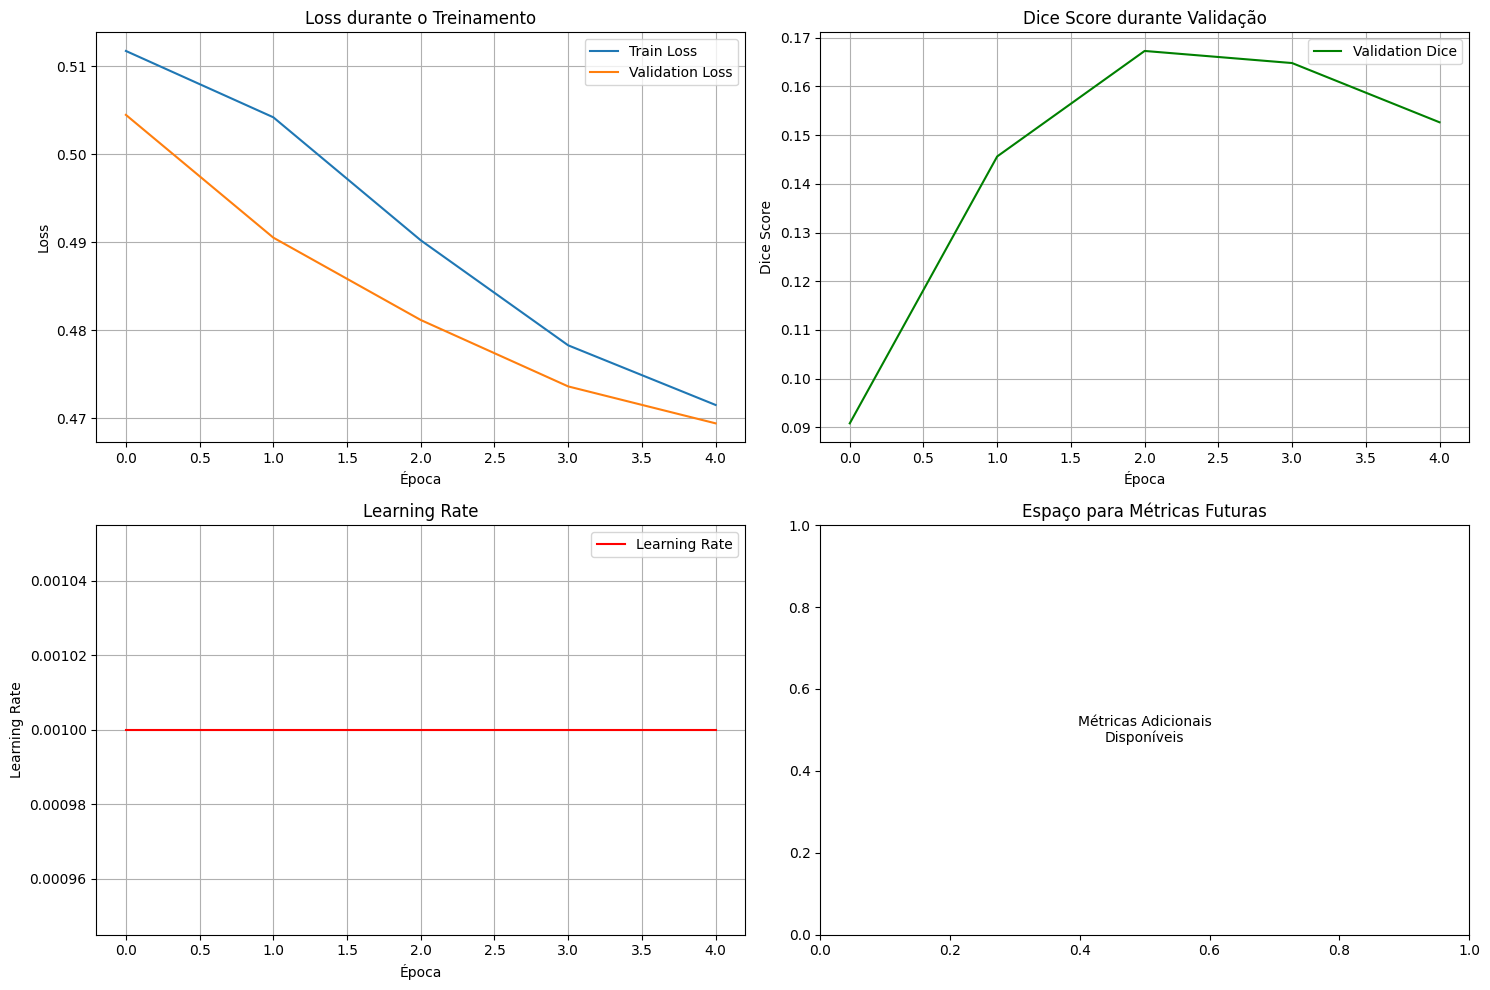

In [ ]:
# Configuração do Treinamento de Teste

config = {
    'learning_rate': 0.001,
    'num_epochs': 5,  # Poucas épocas para teste
    'early_stopping_patience': 3,
    'scheduler_patience': 2,
    'scheduler_factor': 0.5
}

# Configurar otimizador
optimizer = torch.optim.Adam(model.parameters(), lr=config['learning_rate'])

# Configurar scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='min',
    factor=config['scheduler_factor'],
    patience=config['scheduler_patience'],
    verbose=True
)

# Criar gerenciador de treinamento
trainer = TrainingManager(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=combined_loss_fn,
    optimizer=optimizer,
    device=device,
    metrics_calculator=metrics_calculator,
    checkpoint_dir='test_checkpoints'
)

# Executar treinamento de teste
print("🔄 INICIANDO TREINAMENTO DE TESTE")
history = trainer.train(
    num_epochs=config['num_epochs'],
    scheduler=scheduler,
    early_stopping_patience=config['early_stopping_patience']
)

# Plotar resultados
print("\n📊 RESULTADOS DO TREINAMENTO DE TESTE:")
plot_training_metrics(history)

In [91]:
# ⚠️ INICIAR TREINAMENTO
# Descomente a linha abaixo para iniciar o treinamento
# ATENÇÃO: O treinamento pode levar várias horas dependendo da GPU disponível

# history = trainer.train(
#     num_epochs=config['num_epochs'],
#     scheduler=scheduler,
#     early_stopping_patience=config['early_stopping_patience']
# )

# # Plotar métricas após o treinamento
# plot_training_metrics(history)


# 10. Inferência e Visualização dos Resultados

Após o treinamento, vamos implementar funções para fazer inferência em novos dados e visualizar os resultados da segmentação.

In [40]:
class InferenceEngine:
    """Motor de inferência para segmentação de tumores cerebrais"""
    
    def __init__(self, model, device, class_names=None):
        self.model = model
        self.device = device
        self.class_names = class_names or ['Background', 'NCR/NET', 'Edema', 'Enhancing']
        self.colors = [(0, 0, 0), (255, 0, 0), (0, 255, 0), (0, 0, 255)]  # BGR
        
    def predict(self, input_data):
        """Faz predição em um volume de entrada"""
        self.model.eval()
        
        with torch.no_grad():
            # Garantir que input_data tenha dimensões corretas
            if input_data.dim() == 4:  # (C, D, H, W)
                input_data = input_data.unsqueeze(0)  # (1, C, D, H, W)
            
            # Mover para device
            input_data = input_data.to(self.device)
            
            # Predição
            outputs = self.model(input_data)
            
            # Aplicar softmax e obter classes
            probs = F.softmax(outputs, dim=1)
            predictions = torch.argmax(probs, dim=1)
            
            return predictions.cpu().numpy(), probs.cpu().numpy()
    
    def visualize_slice(self, input_volume, prediction, ground_truth=None, 
                       slice_idx=None, modality_idx=1, figsize=(15, 5)):
        """Visualiza uma fatia específica da segmentação"""
        
        if slice_idx is None:
            slice_idx = input_volume.shape[-1] // 2  # Fatia central
        
        # Preparar dados
        input_slice = input_volume[modality_idx, :, :, slice_idx]
        pred_slice = prediction[0, :, :, slice_idx]
        
        # Configurar subplots
        num_plots = 3 if ground_truth is not None else 2
        fig, axes = plt.subplots(1, num_plots, figsize=figsize)
        
        # Imagem original
        axes[0].imshow(input_slice, cmap='gray')
        axes[0].set_title(f'Imagem Original (Fatia {slice_idx})')
        axes[0].axis('off')
        
        # Predição
        axes[1].imshow(input_slice, cmap='gray', alpha=0.7)
        axes[1].imshow(pred_slice, cmap='jet', alpha=0.5)
        axes[1].set_title('Predição')
        axes[1].axis('off')
        
        # Ground truth (se disponível)
        if ground_truth is not None:
            gt_slice = ground_truth[:, :, slice_idx]
            axes[2].imshow(input_slice, cmap='gray', alpha=0.7)
            axes[2].imshow(gt_slice, cmap='jet', alpha=0.5)
            axes[2].set_title('Ground Truth')
            axes[2].axis('off')
        
        # Legenda das classes
        legend_elements = [plt.Rectangle((0,0),1,1, color=np.array(self.colors[i])/255) 
                          for i in range(len(self.class_names))]
        fig.legend(legend_elements, self.class_names, loc='upper right')
        
        plt.tight_layout()
        plt.show()
    
    def visualize_3d_volume(self, prediction, figsize=(12, 8)):
        """Visualiza volume 3D das predições"""
        pred_volume = prediction[0]  # Remover batch dimension
        
        fig, axes = plt.subplots(2, 3, figsize=figsize)
        
        # Diferentes vistas (axial, coronal, sagital)
        views = ['Axial', 'Coronal', 'Sagital']
        
        for class_idx in range(1, 4):  # Excluir background
            class_name = self.class_names[class_idx]
            
            # Obter máscara da classe
            class_mask = (pred_volume == class_idx)
            
            # Projeções máximas
            axial_proj = np.max(class_mask, axis=0)
            coronal_proj = np.max(class_mask, axis=1)
            sagital_proj = np.max(class_mask, axis=2)
            
            # Plotar projeções
            row = (class_idx - 1) // 3
            col = (class_idx - 1) % 3
            
            axes[row, col].imshow(axial_proj, cmap='hot')
            axes[row, col].set_title(f'{class_name} - Projeção Axial')
            axes[row, col].axis('off')
        
        plt.tight_layout()
        plt.show()
    
    def compute_volume_metrics(self, prediction, ground_truth):
        """Calcula métricas para um volume completo"""
        pred_tensor = torch.from_numpy(prediction).unsqueeze(0)
        gt_tensor = torch.from_numpy(ground_truth).unsqueeze(0)
        
        # Converter para format one-hot para cálculo de métricas
        pred_one_hot = F.one_hot(pred_tensor.long(), num_classes=4).permute(0, 4, 1, 2, 3).float()
        
        # Calcular métricas usando nosso calculador
        metrics_calc = SegmentationMetrics(num_classes=4)
        metrics = metrics_calc.compute_all_metrics(pred_one_hot, gt_tensor)
        
        return metrics
    
    def save_prediction(self, prediction, output_path, reference_nii_path=None):
        """Salva predição como arquivo NIfTI"""
        # Converter predição para formato adequado
        pred_volume = prediction[0].astype(np.uint8)  # Remover batch dimension
        
        # Criar imagem NIfTI
        if reference_nii_path:
            # Usar referência para manter metadados
            import nibabel as nib
            ref_img = nib.load(reference_nii_path)
            pred_img = nib.Nifti1Image(pred_volume, ref_img.affine, ref_img.header)
        else:
            pred_img = nib.Nifti1Image(pred_volume, np.eye(4))
        
        # Salvar
        nib.save(pred_img, output_path)
        print(f"✅ Predição salva em: {output_path}")

# Função para testar inferência com dados de validação
def test_inference(model, val_loader, device, num_samples=3):
    """Testa inferência com amostras do conjunto de validação"""
    
    # Criar motor de inferência
    inference_engine = InferenceEngine(model, device)
    
    # Obter algumas amostras
    model.eval()
    with torch.no_grad():
        for i, (data, targets) in enumerate(val_loader):
            if i >= num_samples:
                break
                
            # Fazer predição
            predictions, probs = inference_engine.predict(data[0])  # Primeiro da batch
            
            # Visualizar resultados
            print(f"\n📊 Amostra {i+1}:")
            
            # Calcular métricas
            metrics = inference_engine.compute_volume_metrics(predictions, targets[0].numpy())
            
            print(f"   Dice Score: {metrics['Dice']['Mean']:.4f}")
            
            # Visualizar fatia central
            inference_engine.visualize_slice(
                data[0].numpy(), 
                predictions, 
                targets[0].numpy(),
                slice_idx=None,
                modality_idx=1  # T1ce
            )